In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

**HEART DISEASE DIAGNOSES**

**Introduction:**
 
   Heart disease is a range of conditions which affect one's cardiovascular system. The most common condition is coronary artery disease, in which plaque builds up in arteries, narrowing the vessel walls. If the buildup continues, blood will have a hard time flowing through these vessels. This condition can lead to heart attacks or strokes. Several factors influence an individual's likelihood to be diagnosed with this condition, including high blood pressure, high cholesterol, and smoking. Poor diet, excessive drinking, poor fitness, and diabetes are also factors. 
	
   Using the patient statistics in the UC Irvine University dataset, can we accurately predict the heart disease diagnoses of other patients? We will be using the aforementioned data set that lists 14 factors which influence the likelihood of heart disease, as well as the diagnoses of this patient. The diagnosis column ranges from 1-4, with 1 being no heart disease detected, and 4 being an extreme presence of the disease. We will be keeping 75% of the data for training and using 25% of it for testing. We will test the accuracy, precision and recall of the predictions that R makes, based off of this dataset. We will use a K nearest neighbor prediction calculation to test if the UC Irvine University dataset can accurately predict a diagnosis.

**Research Question:** 

Can we accurately predict if a patient has heart disease based on their age, sex, resting blood pressure, and cholesterol levels? 



**Reading The Data**

*Training Data*

In [2]:
## cp = chest pain, trestbps = resting blood pressure, fbs = fasting blood sugar > 120 mg/dl, restecg = resting electrocardiographic results
## thalach = maximum heart rate achieved, exang = exercise induced chest pain, oldpeak = ST depression induced by exercise
## slope = he slope of the peak exercise ST segment, Value 1: upsloping, Value 2: flat, Value 3: downsloping
## ca = number of major vessels(0-3), thal = 3 = normal; 6 = fixed defect; 7 = reversable defect, num = diagnosis of heart disease

col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_data <- read.table("Data/processed.cleveland.data", 
                         col.names = col_names, sep = ",")


heart_data_analysis <- heart_data |> 
    select(age, sex, chol, trestbps, num)

heart_data_split <- initial_split(heart_data_analysis, prop = 0.75, strata = num)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split)

heart_data_train

age,sex,chol,trestbps,num
<dbl>,<dbl>,<dbl>,<dbl>,<int>
63,1,233,145,0
56,1,236,120,0
57,0,354,120,0
⋮,⋮,⋮,⋮,⋮
58,0,319,136,3
59,1,176,164,3
57,1,131,130,3


## Methods and Analysis

In [3]:
heart_data_train <- heart_data_train |> 
    mutate(num = as.factor(num)) 

heart_data_recipe <- recipe(num ~ age + sex + chol + trestbps, data = heart_data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


[1] 31

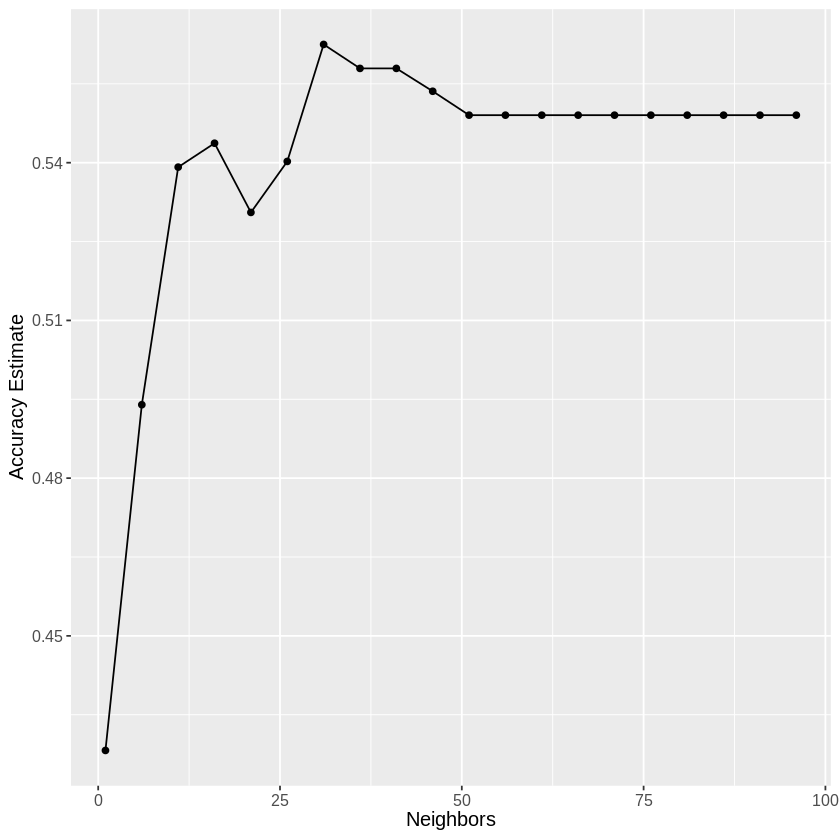

In [4]:
hd_vfold <- vfold_cv(heart_data_train, v = 5, strata = num)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
    add_recipe(heart_data_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = hd_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

best_K <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

accuracies_plot
best_K


**Methods:**

We have cleaned the data by processing missing values and rendering it into tidy format. We have also split 75% of the data for training while keeping 25% for testing. We will proceed by scaling and centering the predictor variables and selecting the 4 columns that we will use to predict a diagnosis: age, sex, trestbps and chol, as well as the diagnosis column: num. We will then create a recipe and workflow for prediction, find out the optimal K through cross-validation and perform a K-nearest neighbor prediction using the optimal K and testing data as the "new" observations. After which, this prediction will be compared to the patient's actual status to calculate the accuracy, precision, and recall of the predictions based on the data from the database. Results will be visualised through a few scatterplots of the various predictor variables against heart disease diagnosis levels.


**Expected Outcomes and Significance:**

We expect to find that this dataset can accurately predict the heart disease diagnosis of patients. This result would be significant since hospitals could compare patient data to this database in order to flag potential sufferers of heart disease. This could lead to a much faster diagnosis which would allow individuals to start management and treatment for the disease earlier. Since the disease would be caught earlier on, its mortality rate would potentially decrease which would save the lives of so many people. Should this data set be accurate in predicting heart disease diagnosis, the question that should be raised is whether such predictive diagnosis can be done for other chronic diseases such as respiratory illnesses given an existing database of patients suffering from such diseases.




**References and Credits:**

- Janosi, A., Steinbrunn, W., Pfisterer, M., and Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.


